In [3]:
from neuralNet import MatrixNeuralNet
from pdes import LinearQuadraticRegulator2D
import matplotlib.pyplot as plt
import numpy as np
from utils import setLogger

setLogger("training")

In [4]:
layers = [2, 20, 20, 3]
network = MatrixNeuralNet( layers)
gamma = {'data': 0, 'gradient': 0, 'residual': 1, 'matrix': 0}
pde = LinearQuadraticRegulator2D( network, gamma )

lrs = [1e-2, 1e-3]
iterations = [1000, 2000]

resu = pde.train(
    interiorPointCount=10,
    dataPointCount=10,
    lrs=lrs,
    iterations=iterations,
    sampling='random'
    )

2024-07-27 13:56:33,816 - training - INFO - 0 / 3000 (0 / 1000), lr:1.0e-02, loss:5.38e+00 (data: 0.00e+00, grad: 0.00e+00, res: 5.38e+00)
2024-07-27 13:56:35,604 - training - INFO - 1000 / 3000 (0 / 2000), lr:1.0e-03, loss:4.86e-07 (data: 0.00e+00, grad: 0.00e+00, res: 4.86e-07)
2024-07-27 13:56:37,197 - training - INFO - 2000 / 3000 (1000 / 2000), lr:1.0e-03, loss:9.41e-08 (data: 0.00e+00, grad: 0.00e+00, res: 9.41e-08)


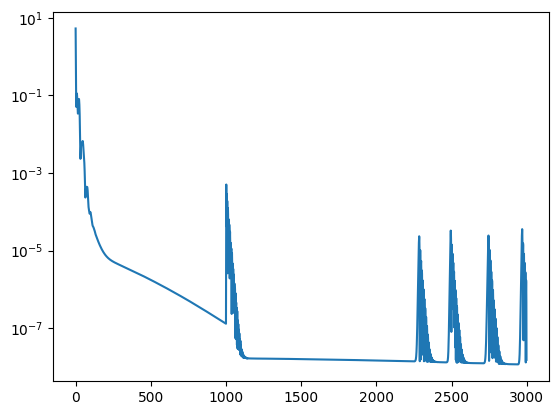

In [6]:
ax = resu['loss'].plot()
ax.set_yscale("log")

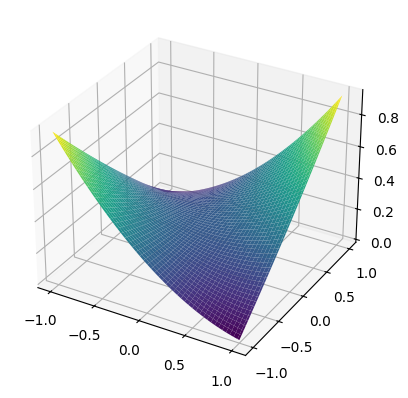

In [7]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(x, y)
space = pde.getEvaluationPoints() 

Z = pde.network.computeValueFunction(space).reshape(-1, 100) - pde.network.computeValueFunction(space).reshape(-1, 100).min()

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z.detach().cpu().numpy(), cmap='viridis');